# AI Framework kennenlernen / Aufgaben

In diesem Notebook werden wir unser AI Wissen anwenden um einfach Aufgaben zu lösen und dabei gerade das AI Framework **PyTorch** kennenlernen.

Eine Einführung und Hilfe erhaltet ihr unter [pytorch.org/tutorials/beginner/basics/intro](https://pytorch.org/tutorials/beginner/basics/intro.html)

## Lineare Regression mit Pytorch

### Daten laden und betrachten

Wir werden das `california housing` dataset verwenden, dass schon automatisch auf Colab zur Verfügung steht.

Wir werden für das Laden dieser Daten die Library `pandas` verwenden. Es arbeitet mit sogenannten `DataFrame`, diese kann man sich wie eine Excel-Tabelle mit Zeilen und Spalten vorstellen.

In [250]:
import pandas as pd

# Daten als DataFrame (df) einlesen
df = pd.read_csv('sample_data/california_housing_train.csv')

# Wir geben einige Infos über das Datenset aus (Anzahl der Zeilen, Name der Spalten, Datentypen, etc.)
df.info()

# Es gibt also insgesamt 9 Spalten und Total 17000 Zeilen

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 17000 entries, 0 to 16999
Data columns (total 9 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   longitude           17000 non-null  float64
 1   latitude            17000 non-null  float64
 2   housing_median_age  17000 non-null  float64
 3   total_rooms         17000 non-null  float64
 4   total_bedrooms      17000 non-null  float64
 5   population          17000 non-null  float64
 6   households          17000 non-null  float64
 7   median_income       17000 non-null  float64
 8   median_house_value  17000 non-null  float64
dtypes: float64(9)
memory usage: 1.2 MB


Ein pandas DataFrame ist eine Datenstruktur in Python, die wie eine Tabelle aussieht, ähnlich wie in Excel: sie hat Zeilen und Spalten. Jede Spalte kann verschiedene Datentypen enthalten (Zahlen, Text, Datumswerte). Damit kannst du Daten einfach speichern, filtern, sortieren, berechnen und analysieren. Man erstellt ein DataFrame meistens aus Listen, Dictionaries oder Dateien (z.B. wie oben aus einem CSV).

Schauen wir uns mal die ersten fünf Zeilen (rows) unserer Tabelle an:

In [251]:
df.head(5)

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value
0,-114.31,34.19,15.0,5612.0,1283.0,1015.0,472.0,1.4936,66900.0
1,-114.47,34.40,19.0,7650.0,1901.0,1129.0,463.0,1.8200,80100.0
2,-114.56,33.69,17.0,720.0,174.0,333.0,117.0,1.6509,85700.0
3,-114.57,33.64,14.0,1501.0,337.0,515.0,226.0,3.1917,73400.0
4,-114.57,33.57,20.0,1454.0,326.0,624.0,262.0,1.9250,65500.0


Damit das Training etwas schneller geht, reduzieren wir die Anzahl der Zeilen auf 30% (5100 Zeilen):

In [252]:
if len(df) > 10_000:
    df = df.sample(frac=0.3, random_state=42)
print('Neue Anzahl Zeilen:', len(df))

Neue Anzahl Zeilen: 5100


### Daten visualisieren

Für das Visualisieren verwenden wir die Library `matplotlib`, welche wir schon in den Python Aufgaben gesehen haben.

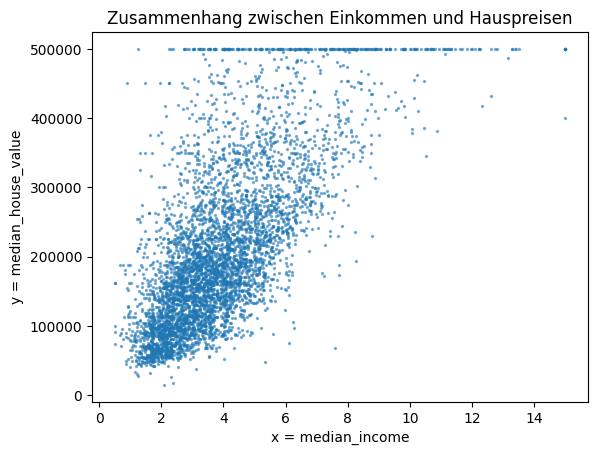

In [253]:
import matplotlib.pyplot as plt

# Wir betrachten den Zusammenhang zwischen den Einkommen (median_income) und den Hauspreisen (median_house_value)
plt.scatter(
    x=df['median_income'],
    y=df['median_house_value'],
    s=2,
    alpha=0.5,
)
plt.xlabel('x = median_income')
plt.ylabel('y = median_house_value')
plt.title('Zusammenhang zwischen Einkommen und Hauspreisen');

Aus dem Bild können wir sehen, dass es einen Zusammenhang zwischen den beiden Variablen gibt. Wir können sagen: Leute, die mehr verdienen, wohnen in teureren Häusern.

### Recap: Lineare Regression

Wie in der Einführung erwähnt, geht es bei der Regression darum, eine optimale Linie zu finden, welche insgesamt am nächsten an den Punkten liegt (der Fehler möglichst gering ist). Bei der linearen Regression, ist das eine simple Linie.

![](../assets/01_lin_reg.png)

In unserem Beispiel, wollen wir anhand des Einkommens (x) vorhersagen, wie teuer das Haus ist (y) in dem die Person wohnt. Die Linie zu finden, dürfte schon fast von Auge möglich sein.

## Daten vorbereiten

Daten werden in PyTorch in sogenannten Tensor-Objekten `torch.Tensor` gespeichert. Als erstes werden wir die Daten in PyTorch Tensors umwandeln. 

Wir betrachten die Spalte `median_income` als X (Eingabe, Feature) und wollen den `median_house_value` als y (Zielwert) vorhersagen.



In [254]:
import torch

# Tensor-Objekte erstellen (typ = 32 bit float) sowie den Datentyp festlegen
# Wir verwenden nun ALLE Features (alle Spalten außer median_house_value)
feature_columns = ['longitude', 'latitude', 'housing_median_age', 'total_rooms', 
                   'total_bedrooms', 'population', 'households', 'median_income']
X = torch.tensor(df[feature_columns].values, dtype=torch.float32)
y = torch.tensor(df[['median_house_value']].values, dtype=torch.float32)

# Betrachen wir, was hier rauskommt. Es sind zwei Tensors mit allen Features und dem Zielwert
print('X (all features):', X)
print('Y (median_house_value):', y)

# Wir können auch schauen, welche Dimensionen (Shape) die Tensoren haben.
# Die erste Dimension ist die Anzahl der Zeilen/Datenpunkte und die zweite Dimension ist die Anzahl der Features (8)
print('X Shape:', X.shape)
print('y Shape:', y.shape)

X (all features): tensor([[-1.2087e+02,  3.7770e+01,  9.0000e+00,  ...,  2.4600e+03,
          9.2300e+02,  3.5959e+00],
        [-1.1814e+02,  3.4110e+01,  5.2000e+01,  ...,  1.1530e+03,
          4.1400e+02,  8.1124e+00],
        [-1.2005e+02,  3.6980e+01,  1.6000e+01,  ...,  2.4630e+03,
          6.9700e+02,  2.5288e+00],
        ...,
        [-1.2043e+02,  3.4950e+01,  4.3000e+01,  ...,  6.9200e+02,
          3.1000e+02,  3.6815e+00],
        [-1.1814e+02,  3.3770e+01,  4.9000e+01,  ...,  1.3010e+03,
          6.4800e+02,  3.2917e+00],
        [-1.1714e+02,  3.2700e+01,  4.4000e+01,  ...,  8.6900e+02,
          2.1200e+02,  1.9338e+00]])
Y (median_house_value): tensor([[142700.],
        [500001.],
        [ 61800.],
        ...,
        [181800.],
        [307400.],
        [ 89400.]])
X Shape: torch.Size([5100, 8])
y Shape: torch.Size([5100, 1])


**Scaling**

Für die Analyse, ist es wichtig, dass die Werte in einem genormten Bereich sind. Oft wird der Bereich -1 bis 1 oder 0 bis 1 verwendet. Wir wollen unsere Daten in den Bereich zwischen 0 und 1 bringen. Dazu können wir alle Daten durch den maximalen Wert teilen:

In [255]:
X = X / X.max()
y = y / y.max()

**Beispiel:**

Daten: [1, 2, 5, 8, 10]

max = 10

map:
- 1 / 10 = 0.1
- 2 / 10 = 0.2
- 5 / 10 = 0.5
- 8 / 10 = 0.8
- 10 / 10 = 1.0

### Datasets, Dataloader

In PyTorch gibt es zwei wichtige Konzepte, die Datasets und Dataloaders.

#### Datasets
Wir werden ein Dataset erstellen, welches die Daten enthält.
Ein Datenset speichert die Daten und gibt diese mit __getitem__ zurück. Zusätzlich kann mit __len__ die Anzahl Daten im Datenset abgefragt werden. Wenn wir unser eigenes Datenset erstellen "erben" wir von der torch `Dataset` Klasse und müssen dann noch diese beiden Funktionen selber programmieren:

In [256]:
from torch.utils.data import Dataset, DataLoader, random_split

class HousingDataset(Dataset):
    def __init__(self, X, y):
        self.X = X
        self.y = y

    # Die Funktion kann anschliessen mit len(dataset) aufgerufen werden
    def __len__(self):
        return len(self.X)

    # Die Funktion kann anschliessend mit dataset[index] aufgerufen werden und gibt X und y zurück
    def __getitem__(self, index):
        return self.X[index], self.y[index]


Jetzt müssen wir unsere Daten (X und y) noch in unser Housing-Dataset laden:

In [257]:
dataset = HousingDataset(X, y)

**Train/Test Set**

Wir werden nun dieses Datenset aufteilen, und zwar in Daten, welche wir fürs Trainieren verwenden (80%) und Daten, welche wir nur für die Validierung verwenden (20%).

Das Training-Datenset verwenden wir um unser Modell zu trainieren, das Validierung-Datenset verwenden wir nach dem Training um das Modell zu testen. Um eine aussagekräftige Test-Genauigkeit zu bekommen ist es wichtig, dass Modell mit Daten zu testen welche es nicht schon während dem Training gesehen und gelernt hat.

In [258]:
train_dataset, val_dataset = random_split(dataset=dataset, lengths=[0.8, 0.2])
print('train:', len(train_dataset), '| val:', len(val_dataset))

train: 4080 | val: 1020


#### Dataloader
Ein Datenloader teilt die Daten in Batches auf. Ein Batch ist eine Gruppe von Datepunkten. Es ist viel schneller und oft auch genauer ein Modell mit Batches zu trainieren statt mit einzelnen Daten. Wir verwenden das `shuffle` Argument, welches die Daten jedes mal zufällig mischt. Das macht für das Training Sinn, beim validieren (testen) wollen wir immer das genau gleiche Datenset, daher mischen wir dort nicht.

In [259]:
BATCH_SIZE = 128  # Unser Batch Size ist 128, was bedeutet, dass wir 128 Datenpunkte gleichzeitig in das Netzwerk füttern
train_loader = DataLoader(dataset=train_dataset, batch_size=BATCH_SIZE, shuffle=True)
val_loader = DataLoader(dataset=val_dataset, batch_size=BATCH_SIZE, shuffle=False)

## Training vorbereiten

Um das Training zu erleichtern, benützten wir die Python Bibliothek [**PyTorch Lightning**](https://lightning.ai/). Lightning stellt Funktionen zur Verfügung, die wir sonst alle selbst schreiben müssten.

Wir müssen als ersten unser Neuronales Netz definieren, welches wir benützten wollen.  
Dazu benützten wir ein Lightning-Module in welchem wir die Schichten (Layers) unseres neuronalen Netzes definieren.  
Wir starten mit einem ganz simplen Netz mit nur einem Layer und einem Neuron.

Der Code unten macht sehr viel und ist relativ komplex. Überflieg ihn, es ist oke, wenn du das meiste nicht verstehst.

In [260]:
from pytorch_lightning import LightningModule, Trainer

class LinearRegression(LightningModule):
    # Ein Lightning Modul definiert in seiner __init__ Funktion die Schichten des Modells
    def __init__(self, lr = 0.001):
        super().__init__()
        # Unser Modell besteht nun aus mehreren Schichten:
        # 1. Schicht: 8 Eingabe-Features -> 32 Neuronen (versteckte Schicht)
        self.layer1 = torch.nn.Linear(in_features=8, out_features=32)
        self.relu1 = torch.nn.ReLU()
        
        # 2. Schicht: 32 Neuronen -> 16 Neuronen (zweite versteckte Schicht)
        self.layer2 = torch.nn.Linear(in_features=32, out_features=16)
        self.relu2 = torch.nn.ReLU()
        
        # 3. Schicht: 32 Neuronen -> 1 Output (Vorhersage)
        self.layer3 = torch.nn.Linear(in_features=16, out_features=1)

        # Wir speichern die Lernrate
        self.lr = lr

        # Folgende Metriken wollen wir loggen:
        self.logged_metrics = {
            "train_loss": [],
            "val_loss": [],
            "train_step": [],
            "train_epoch": [],
            "val_step": [],
            "val_epoch": [],
            "weights": [],
        }

    # In der forward Funktion definieren wir, wie die Eingabe durch das Modell geht (x ist ein Batch von Daten)
    def forward(self, x):
        # Erste Schicht + Aktivierung
        x = self.layer1(x)
        x = self.relu1(x)
        
        # Zweite Schicht + Aktivierung
        x = self.layer2(x)
        x = self.relu2(x)
        
        # Ausgabe-Schicht (keine Aktivierung)
        x = self.layer3(x)
        return x

    # In der training_step Funktion definieren wir, was in einem Trainingsschritt passiert
    def training_step(self, train_batch, batch_idx):
        # Hole die Eingabe (x) und den Zielwert (y_true) aus dem Batch
        x, y = train_batch
        # Mache eine Vorhersage (y_pred) mit dem Modell
        y_pred = self(x)
        # Berechne den Fehler (loss) zwischen Vorhersage und Zielwert
        loss = torch.nn.functional.mse_loss(input=y_pred, target=y)
        # Logge den Fehler, damit wir den Trainingsfortschritt beobachten können
        self.logged_metrics["train_loss"].append(loss.item())
        self.logged_metrics["train_step"].append(self.global_step)
        self.logged_metrics["train_epoch"].append(self.current_epoch)
        return loss

    # In der validation_step Funktion überprüfen wir, wie gut unsere Modell auf den Testdaten funktioniert
    # Inhaltlich ist es fast identisch mit dem training_step. Nur die Daten sind anders
    def validation_step(self, val_batch, batch_idx):
        x, y = val_batch
        y_pred = self(x)
        loss = torch.nn.functional.mse_loss(input=y_pred, target=y)
        self.logged_metrics["val_loss"].append(loss.item())
        self.logged_metrics["val_step"].append(self.global_step)
        self.logged_metrics["val_epoch"].append(self.current_epoch)
        # Für komplexere Modelle speichern wir nur den ersten Layer's Gewichte
        self.logged_metrics["weights"].append((self.layer1.weight[0, 0].item(), self.layer1.bias[0].item()))
        return loss

    # Der Optimizer optimiert unser Modell. Hier wird auch die Lernrate (lr) definiert
    # Die Lernrate gibt an, wie gross die Schritte sind, die der Optimizer macht. Dazu mehr später
    def configure_optimizers(self):
        return torch.optim.Adam(self.parameters(), lr=self.lr)

## Training

Das Ziel beim Training ist es, dass das Modell lernt anhand vom Input `X`, den Output `y` vorherzusagen. Dazu zeigen wir dem Modell unsere X Werte, es macht eine Vorhersage, wir vergleichen die Vorhersage (`y_pred`) mit dem tatsächlichen Wert `y` und das Modell passt sich leicht an, damit beim nächsten mal die Vorhersage etwas näher bei `y` liegt. Die Differenz zwischen der vorhersage `y_pred` und `y` nennen wir den "loss" (Deutsch: Fehler).

Nun zum eigentlichen Training: Die `Trainer` Klasse übernimmt für uns das Training. Mit `max_epochs` geben wir an, wie viel mal wir durch das gesamte Trainings-Datenset iterieren wollen.

Ist dieser Wert zu klein, dann kommt es zu **Unterfitting** (das Modell lernt zu wenig), ist dieser zu hoch, zu **Overfitting** (das Modell lernt die Daten auswendig). In der Praxis müssen wir also den optimalen Wert für die Anzahl Epochen finden.

Die Lernrate definiert wie stark sich das Modell bei einem Trainingsschritt anpasst. Bei einer hohen Lernrate lernt dass Modell schneller aber unruhiger, bei einer kleinen dauert das Training länger ist aber stabiler. Auch hier ist es eine Kunst einen passenden Wert zu finden.

Die **Lernrate** und die **Anzahl Epochen** sind die wichtigsten Parameter um ein schnelles Training mit guten Ergebnissen zu erhalten. Solche Parameter werden **Hypterparameter** genannt.

In [261]:
EPOCHS = 100
LEARNING_RATE = 0.001

Wir erstellen einen Trainer und eine Instanz unseres Modells von oben. Da es sich bei unserem Modell um ein sehr einfaches handelt, trainieren wir auf der CPU (`accelerator`). Grössere Modelle, wie wir sie später bauen, sollten auf der GPU trainiert werden, sonst dauert das Training sehr lange...

In [262]:
trainer = Trainer(max_epochs=EPOCHS, accelerator='gpu')
model = LinearRegression(lr=LEARNING_RATE)

💡 Tip: For seamless cloud uploads and versioning, try installing [litmodels](https://pypi.org/project/litmodels/) to enable LitModelCheckpoint, which syncs automatically with the Lightning model registry.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


Jetzt können wir unser Modell trainieren. Die `fit` Funktion ruft wiederholt die `training_step` Funktion unseres Modells auf und übergibt ihr die X und y Daten aus unserem Datenset.

In [263]:
trainer.fit(model, train_dataloaders=train_loader, val_dataloaders=val_loader)

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name   | Type   | Params | Mode 
------------------------------------------
0 | layer1 | Linear | 288    | train
1 | relu1  | ReLU   | 0      | train
2 | layer2 | Linear | 528    | train
3 | relu2  | ReLU   | 0      | train
4 | layer3 | Linear | 17     | train
------------------------------------------
833       Trainable params
0         Non-trainable params
833       Total params
0.003     Total estimated model params size (MB)
5         Modules in train mode
0         Modules in eval mode

  | Name   | Type   | Params | Mode 
------------------------------------------
0 | layer1 | Linear | 288    | train
1 | relu1  | ReLU   | 0      | train
2 | layer2 | Linear | 528    | train
3 | relu2  | ReLU   | 0      | train
4 | layer3 | Linear | 17     | train
------------------------------------------
833       Trainable params
0         Non-trainable params
833       Total params
0.003     Total estimated model params size (MB)
5         Modules

Sanity Checking: |          | 0/? [00:00<?, ?it/s]

/home/nico/source/ai-challange/notebooks/.venv/lib/python3.12/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:433: The 'val_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=15` in the `DataLoader` to improve performance.
/home/nico/source/ai-challange/notebooks/.venv/lib/python3.12/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:433: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=15` in the `DataLoader` to improve performance.
/home/nico/source/ai-challange/notebooks/.venv/lib/python3.12/site-packages/pytorch_lightning/loops/fit_loop.py:310: The number of training batches (32) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.


Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=100` reached.


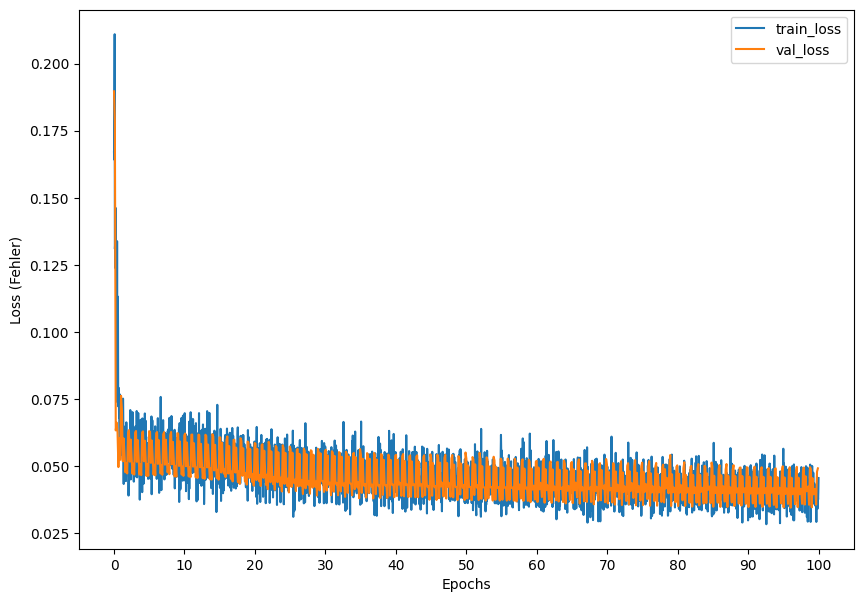

In [264]:
# Nun können wir uns die Trainings- und Validierungsfehler anschauen
train_loss = model.logged_metrics['train_loss']
val_loss = model.logged_metrics['val_loss']

plt.figure(figsize=[10, 7])
plt.plot(train_loss, label='train_loss')
plt.plot(
    [i * (len(train_loss) / len(val_loss)) for i in range(len(val_loss))],
    val_loss,
    label='val_loss',
)
# Die X-Achse mit Epochs beschriften.
plt.xticks(
    ticks=[i * (len(train_loss) // 10) for i in range(11)],
    labels=[f'{i*(EPOCHS//10)}' for i in range(11)],
)
plt.xlabel('Epochs')
plt.ylabel('Loss (Fehler)')
plt.legend();

Wir sehen, dass der Fehler zuerst schnell abnimmt, sich jedoch im Verlauf immer langsamer verringert. Sobald der Loss gegen Ende nicht weiter sinkt, deutet das darauf hin, dass das Modell nichts Neues mehr lernen kann.

Da unser Modell nun 8 Eingabe-Features verwendet, können wir nicht mehr einfach eine Linie plotten. Stattdessen visualisieren wir die Vorhersagen vs. die echten Werte:

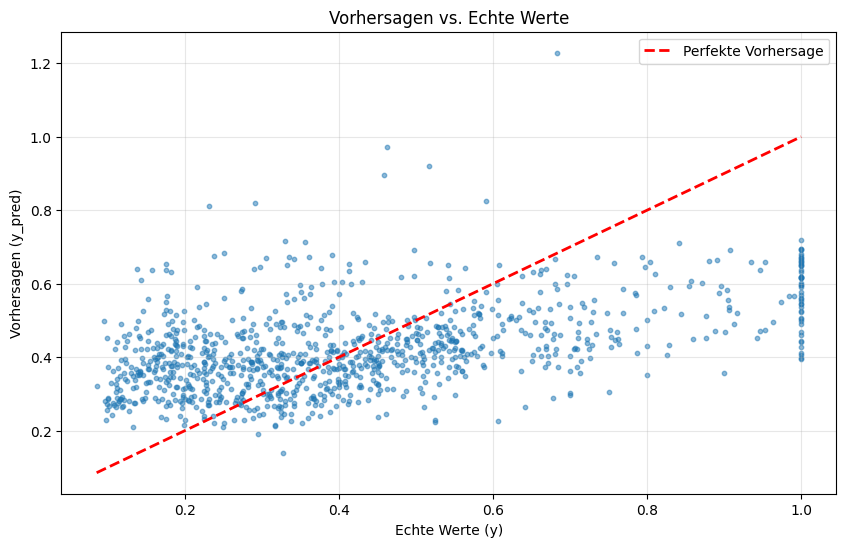

In [265]:
# Wir machen Vorhersagen auf dem Validierungsset
model.eval()  # Modell in Evaluierungsmodus setzen
with torch.no_grad():
    X_val = val_dataset.dataset.X[val_dataset.indices]
    y_val = val_dataset.dataset.y[val_dataset.indices]
    y_pred = model(X_val)

# Plotten: Echte Werte vs. Vorhersagen
plt.figure(figsize=(10, 6))
plt.scatter(y_val.numpy(), y_pred.numpy(), alpha=0.5, s=10)
plt.plot([y_val.min(), y_val.max()], [y_val.min(), y_val.max()], 'r--', lw=2, label='Perfekte Vorhersage')
plt.xlabel('Echte Werte (y)')
plt.ylabel('Vorhersagen (y_pred)')
plt.title('Vorhersagen vs. Echte Werte')
plt.legend()
plt.grid(True, alpha=0.3)
# Je näher die Punkte an der roten Linie sind, desto besser die Vorhersage

### Was hat das Model gelernt?

Da unser Modell nun mehrere Schichten und viele Gewichte hat (8x64 + 64x32 + 32x1 = 2592 Parameter!), können wir nicht mehr einfach das Gewicht und Bias anzeigen wie bei einer einfachen Geraden.

Stattdessen können wir uns die **Feature Importance** anschauen - welche Eingabe-Features haben den größten Einfluss auf die Vorhersage?

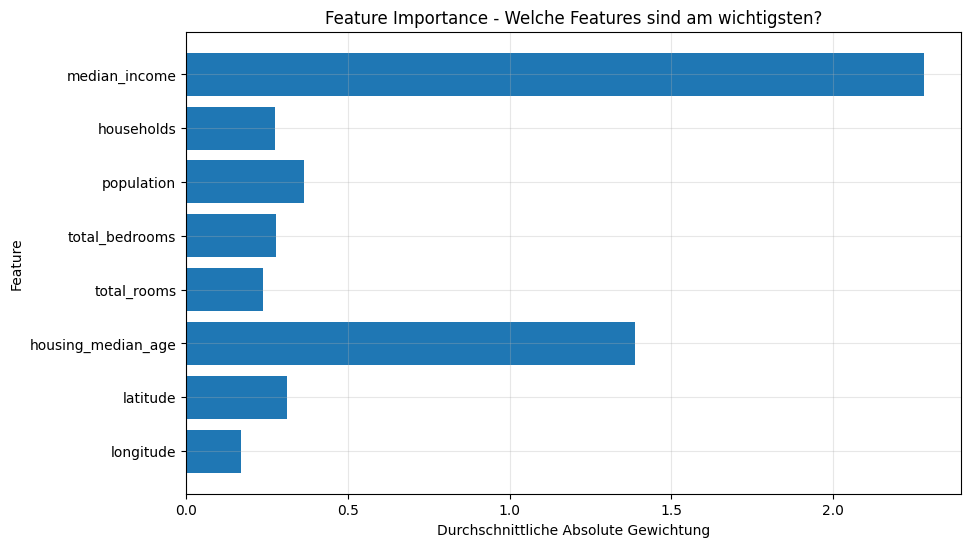

In [266]:
# Import numpy falls noch nicht importiert
import numpy as np

# Feature Importance: Durchschnittliche absolute Gewichte der ersten Schicht
feature_names = ['longitude', 'latitude', 'housing_median_age', 'total_rooms', 
                 'total_bedrooms', 'population', 'households', 'median_income']

# Berechne die durchschnittliche absolute Gewichte für jedes Feature
weights = model.layer1.weight.detach().cpu().numpy()
feature_importance = np.abs(weights).mean(axis=0)

# Visualisierung
plt.figure(figsize=(10, 6))
plt.barh(feature_names, feature_importance)
plt.xlabel('Durchschnittliche Absolute Gewichtung')
plt.ylabel('Feature')
plt.title('Feature Importance - Welche Features sind am wichtigsten?')
plt.grid(True, alpha=0.3)
# Je größer der Balken, desto wichtiger ist das Feature für die Vorhersage

Besonders spannend ist es zu sehen, wie sich das Modell während dem Training verändert hat. 

Da wir nun ein komplexes Modell mit vielen Parametern haben, visualisieren wir stattdessen:
1. Wie sich die **Gewichte eines einzelnen Neurons** über das Training ändern
2. Wie sich die **Vorhersagequalität** verbessert

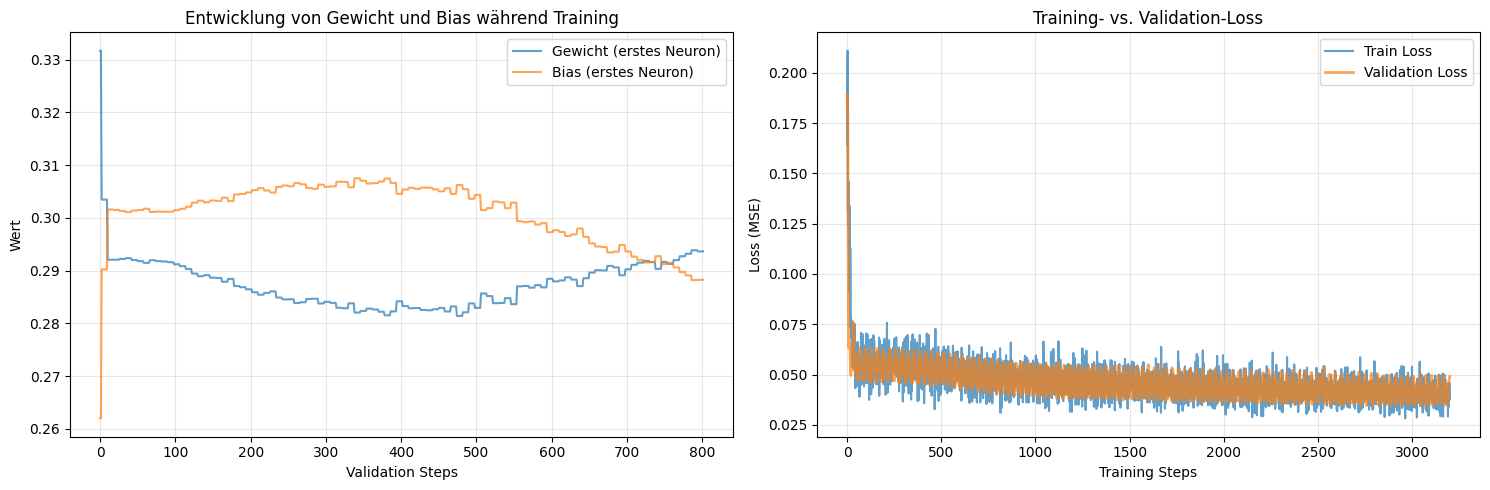

In [267]:


# Visualisierung 1: Entwicklung der Gewichte während des Trainings
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))

# Plot 1: Gewicht und Bias eines einzelnen Neurons über Zeit
weights_history = model.logged_metrics['weights']
weights = [w[0] for w in weights_history]
biases = [w[1] for w in weights_history]

ax1.plot(weights, label='Gewicht (erstes Neuron)', alpha=0.7)
ax1.plot(biases, label='Bias (erstes Neuron)', alpha=0.7)
ax1.set_xlabel('Validation Steps')
ax1.set_ylabel('Wert')
ax1.set_title('Entwicklung von Gewicht und Bias während Training')
ax1.legend()
ax1.grid(True, alpha=0.3)

# Plot 2: Vergleich Train vs Validation Loss
ax2.plot(model.logged_metrics['train_loss'], label='Train Loss', alpha=0.7)
# Resample val_loss to match train_loss length for visualization
val_indices = np.linspace(0, len(model.logged_metrics['train_loss'])-1, len(model.logged_metrics['val_loss']))
ax2.plot(val_indices, model.logged_metrics['val_loss'], label='Validation Loss', alpha=0.7, linewidth=2)
ax2.set_xlabel('Training Steps')
ax2.set_ylabel('Loss (MSE)')
ax2.set_title('Training- vs. Validation-Loss')
ax2.legend()
ax2.grid(True, alpha=0.3)

plt.tight_layout()

# Wie weiter?

Versucht nun folgendes, um das Model zu verbessern und eure Wissen über neuronale Netzwerke zu vertiefen

### Basics:

- Welcher Einfluss haben folgende Hyperparameter auf das Training und den Trainings-Erfolg? Wie verändert sich die Lernkurve?
  - Anzahl Epochen `EPOCHS`
  Antwort:
    - Bei wenigen Epochen hat das Model zu wenig zeit um zu Lernen.
    - Bei vielen Epochen lernt das Model die Daten auswendig
    - Bei der Optimalen Anzahl hat das Modell genug Zeit zum Lernen hat aber zu wenig das es die Daten auswendig lernt.


  - Learnrate `lr` in der Funktion `configure_optimizers()`
  Antwort:
    - Wenn die Lernrate klein eingestellt ist lernt das Modell sehr langsam.
    - Wenn die Lernrate hoch eingestellt ist lernt das Modell instabil, was zu einem höheren Verlust wird.
    - Wenn die Lernrate korrekt eingestellt ist lernt es gleichmässig und verliert nicht übermässig Daten.

  - Batch Grösse `BATCH_SIZE`
  Antwort:
    - Kleine Batches bringen mehr Updates pro Epoche, was aber zu einer Unruhigen Lernkurve führt.
    - Grosse Batches bringen weniger Updates pro Epoche was zu Langsamen lernen führt.
    - Mit der optimalen Anzahl ist es stabil und schnell.

### Fortgeschritten:

- Füge mehr Inputs hinzu. Gehe davon wie folgt vor
  - Plotte den Zusammenhang zwischen den anderen Inputs (z.b. `total_rooms`) und unserem Ziel (`median_income`). Siehst du einen Zusammenhang?
  - Wo im Notebook musst du Änderungen machen, damit das Model mehr Inputs verwendet? Tipp: Es sind zwei Stellen

### Sehr Fortgeschritten:
- Erweitere das neuronale Netzwerk (mit einem Input), in dem du mehrere Layer (Schichten), gefolgt von einer Aktivierungsfunktion (ReLU, Details folgen in der kommenden Woche) hinzufügt. Kann das Netzwerk nun auch nicht-lineare Zusammenhänge lernen (nicht nur eine Gerade, sondern Linie mit Kurven)?
  - Tipp: Hier ein Beispiel eines Netzwerk mit 2 Layers (Schichten):
    ```python
    # in __init__
    self.layer = torch.nn.Linear(in_features=1, out_features=1)
    self.relu = torch.nn.ReLU()
    self.layer2 = torch.nn.Linear(in_features=1, out_features=1)

    # in forward:
    x = self.layer(x)
    x = self.relu(x)
    x = self.layer2(x)
    return x
    ```
  - Achtung: Die Visualisierung der Gewichte und Bias macht keinen Sinn mehr wenn du weitere Layers hinzufügst.